In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate as spi
plt.style.use('seaborn-white')
from util import plot_diff_lambdas_distances
%matplotlib inline

In [2]:
filename = 'data/ltb_cheese2.csv'
df = pd.read_csv(filename)

In [3]:
# df.values
6.22435157e+02*8e-7

0.0004979481256

In [4]:
df[df.om_lambdas==0].count()
df.om_lambdas.nunique()
# df = df.head(2500)

50

In [5]:
# zs = np.linspace(0.2, 1, 50)
# z_lens = []
# for z in zs:
#     z_lens.extend([z]*50)

# df['z_lens'] = z_lens
# df['comoving_lens'] = df.DL*(1+df.z_lens)
# df['raw_rs'] = df.rs - df.comoving_lens
# df['M'] = 1474e12 / 3.086e22
# df.to_csv('data/diff_lambdas_bigger_redshifts2.csv', index=False)

In [6]:
length_scale = 3.086e22
H_0 = 7.56e-27 * length_scale
# M_total = 1474e12 / length_scale

preds_first_order = []
preds_frw = []
preds_ishak = []
for index, row in df.iterrows():
    M_total = row.M
    Lambda = 3*row.om_lambdas*H_0**2
    enclosed_r = row.DL*row.theta
    rho_frw_initial = (1-row.om_lambdas)*3*H_0**2/(8*np.pi)
    r_h = (3*M_total/(4*np.pi*rho_frw_initial))**(1./3)
    
    def mass(r):
        initial_rh = (3*M_total/(4*np.pi*rho_frw_initial))**(1./3)
        rlimit = initial_rh*0.5
        if r > rlimit:
            return M_total
        else:
            c = 10
            Rvir = rlimit/100
            Rs = Rvir/c
            rho0 = M_total/(4*np.pi*Rs**3*(np.log((Rs + rlimit)/Rs) - rlimit/(Rs + rlimit)))
            return 4*np.pi*rho0*Rs**3*(np.log((Rs+r)/Rs) - r/(Rs+r))

    def rho(r):
        initial_rh = (3*M_total/(4*np.pi*rho_frw_initial))**(1./3)
        rlimit = initial_rh*0.5
        if r > rlimit:
            return 0
        else:
            c = 10
            Rvir = rlimit/100
            Rs = Rvir/c
            rho0 = M_total/(4*np.pi*Rs**3*(np.log((Rs + rlimit)/Rs) - rlimit/(Rs + rlimit)))
            return rho0/(r/Rs)/(1 + r/Rs)**2

    def projected_mass(r):
        initial_rh = (3*M_total/(4*np.pi*rho_frw_initial))**(1./3)
        rlimit = initial_rh*0.5
        if r > rlimit:
            return M_total
        else:
            c = 10
            Rvir = rlimit/100
            Rs = Rvir/c
            
            g = 1/(np.log(1+c) - c/(1+c))
            Rtilde = r / Rvir
            if r > Rs:
                c_inverse = np.arccos(1/c/Rtilde)
            else:
                c_inverse = np.arccosh(1/c/Rtilde)
            return 1/(np.log(1+c*Rtilde) - c*Rtilde/(1+c*Rtilde))*mass(r)*(c_inverse/np.abs(c**2*Rtilde**2-1)**(1/2) + np.log(c*Rtilde/2))

    M = projected_mass(enclosed_r)
    
    A_frw = 4*M/(row.DL*row.theta) + 15*np.pi*M**2/4/(row.DL*row.theta)**2 + 401/12*M**3/(row.DL*row.theta)**3
    frw = row.comoving_lens/(A_frw/row.theta -1)
#     print("A_FRW=====", A_frw, frw)
    
    A_ishak = 4*M/(row.DL*row.theta) + 15*np.pi*M**2/4/(row.DL*row.theta)**2 + 305/12*M**3/(row.DL*row.theta)**3 - Lambda*row.DL*row.theta*row.exit_rhs/3
    ishak = row.comoving_lens/(A_ishak/row.theta -1)
    
    
    preds_frw.append(frw)
    preds_ishak.append(ishak)

df['preds_frw'] = preds_frw
df['preds_ishak'] = preds_ishak

df['numerical'] = df.raw_rs/df.preds_frw
df['ishak'] = df.preds_ishak/df.preds_frw

In [7]:
df.head()

,DL,M,comoving_lens,exit_rhs,numerical_thetas,om_lambdas,raw_rs,rs,step,theta,z_lens,preds_frw,preds_ishak,numerical,ishak
0,362.678499,4.776410e-08,398.946349,1.096901,8.000000e-07,0.000000,23.739345,422.685694,1.000000e-08,8.000000e-07,0.1,23.739055,23.739055,1.000012,1.0
1,363.110079,4.776410e-08,399.421087,1.103702,8.000000e-07,0.018367,23.962073,423.383160,1.000000e-08,8.000000e-07,0.1,23.961772,23.961773,1.000013,1.0
2,363.543684,4.776410e-08,399.898052,1.110674,8.000000e-07,0.036735,24.191063,424.089115,1.000000e-08,8.000000e-07,0.1,24.190816,24.190818,1.000010,1.0
3,363.979329,4.776410e-08,400.377262,1.117826,8.000000e-07,0.055102,24.426743,424.804006,1.000000e-08,8.000000e-07,0.1,24.426500,24.426502,1.000010,1.0
4,364.417035,4.776410e-08,400.858738,1.125165,8.000000e-07,0.073469,24.669392,425.528130,1.000000e-08,8.000000e-07,0.1,24.669158,24.669160,1.000009,1.0


In [8]:
stats = df[['om_lambdas', 'numerical', 'ishak']].groupby('om_lambdas').agg(['mean', 'std', 'count'])
stats.columns = [' '.join(col).strip() for col in stats.columns.values]
stats['numerical mean std'] = stats['numerical std']/np.sqrt(stats['numerical count'])
stats['ishak mean std'] = stats['ishak std']/np.sqrt(stats['ishak count'])
stats.head()

,numerical mean,numerical std,numerical count,ishak mean,ishak std,ishak count,numerical mean std,ishak mean std
om_lambdas,,,,,,,,
0.000000,1.000011,1.368022e-06,2,1.0,7.213005e-13,2,9.673378e-07,5.100365e-13
0.018367,1.000012,1.025450e-06,2,1.0,6.542149e-10,2,7.251023e-07,4.625998e-10
0.036735,1.000011,7.538435e-07,2,1.0,1.326807e-09,2,5.330479e-07,9.381946e-10
0.055102,1.000010,2.827576e-07,2,1.0,2.019401e-09,2,1.999398e-07,1.427932e-09
0.073469,1.000009,4.509934e-07,2,1.0,2.732960e-09,2,3.189005e-07,1.932494e-09


In [9]:
stats['numerical mean'] = stats['numerical mean'] - 1
stats['ishak mean'] = stats['ishak mean'] - 1

In [10]:
stats = stats[stats['numerical mean'].abs() < 0.001]

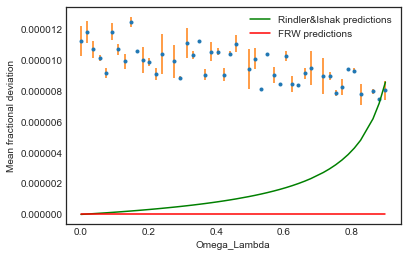

In [11]:
scale = 1
# stats = stats.head(49)
plt.plot(stats.index, stats['numerical mean']/scale, '.', label='__nolegend__')
# plt.plot(stats.index, stats['numerical first order mean']/scale, 'b-', label='with second order corrections')
plt.errorbar(stats.index, stats['numerical mean']/scale, yerr=stats['numerical mean std']/scale, linestyle='none', label='__nolegend__')
plt.xlabel('Omega_Lambda')
plt.ylabel('Mean fractional deviation')
plt.plot(stats.index, stats['ishak mean']/scale, 'g-', label='Rindler&Ishak predictions')
plt.plot(stats.index, [0/scale]*len(stats.index), 'r-', label='FRW predictions')
# plt.ylim((-0.0008, 0.0008))
plt.legend()
# plt.savefig('images/half_analytical.png',  dpi=400)